# Libraries and Initial Methods

In [1]:
import os
import cv2
import csv
import math
import imutils
%matplotlib inline
import numpy as np
from PIL import Image
from time import sleep
from tqdm.notebook import tqdm
from scipy import ndimage as nd
from scipy.ndimage import rotate
from matplotlib import pyplot as plt

In [2]:
def showimage(myimage, figsize=[7,7], pltTitle = "", figax =[-1,-1]):
    if (myimage.ndim>2):  #This only applies to RGB or RGBA images (e.g. not to Black and White images)
        myimage = myimage[:,:,::-1] #OpenCV follows BGR order, while matplotlib likely follows RGB order
    if(figax[0] == -1):     
        fig, ax = plt.subplots(figsize=figsize)
    else:
        fig = figax[0]
        ax = figax[1]
    ax.imshow(myimage, cmap = 'gray', interpolation = 'bicubic')
    plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
    plt.title(pltTitle)
    plt.show()
    
#https://www.freedomvc.com/index.php/2021/10/16/gabor-filter-in-edge-detection/

In [3]:
def partition(arr, low, high):
    i = (low-1)         # index of smaller element
    pivot = arr[high]     # pivot
 
    for j in range(low, high):
 
        # If current element is smaller than or
        # equal to pivot
        if arr[j] >= pivot:
 
            # increment index of smaller element
            i = i+1
            arr[i], arr[j] = arr[j], arr[i]
 
    arr[i+1], arr[high] = arr[high], arr[i+1]
    return (i+1)

In [4]:
def quickSort(arr, low, high):
    if len(arr) == 1:
        return arr
    if low < high:
 
        # pi is partitioning index, arr[p] is now
        # at right place
        pi = partition(arr, low, high)
 
        # Separately sort elements before
        # partition and after partition
        quickSort(arr, low, pi-1)
        quickSort(arr, pi+1, high)

In [5]:
def drawLines(image, arrayPoints, figsize=[7,7], pltTitle = ""):
    fig, ax = plt.subplots(figsize=figsize)
    for index in range(0, len(arrayPoints)):
        p1Index = index-1
        if(p1Index < 0):
            p1Index = len(arrayPoints)-1
        p1 = arrayPoints[p1Index]
        p2 = arrayPoints[index]
        plt.plot([p1[0], p2[0]], [p1[1], p2[1]])
    showimage(image, figax = [fig, ax], pltTitle = pltTitle)

In [6]:
def drawSingleLines(image, Lines, figsize=[7,7], pltTitle = ""):
    fig, ax = plt.subplots(figsize=figsize)
    
    for index in range(0, len(Lines)):
        p1 = Lines[index][0]
        p2 = Lines[index][1]
        plt.plot([p1[0], p2[0]], [p1[1], p2[1]])
    showimage(image, figax = [fig, ax], pltTitle = pltTitle)

# Step 1: Image Loading

In [7]:
def apply_filter(img, filters):
    #Normalize Image
    img = (img - img.mean()) / img.std()

    # This general function is designed to apply filters to our image
    # First create a numpy array the same size as our input image
    newimage = np.zeros_like(img)
    appliedFilters = []
    # Starting with a blank image, we loop through the images and apply our Gabor Filter
    # On each iteration, we take the highest value (super impose), until we have the max value across all filters
    # The final image is returned
    depth = -1 # remain depth same as original image
     
    for kern in filters:  # Loop through the kernels in our GaborFilter
        image_filter = np.sqrt(nd.convolve(img, np.real(kern), mode='wrap')**2 +
                   nd.convolve(img, np.imag(kern), mode='wrap')**2)
        # Using Numpy.maximum to compare our filter and cumulative image, taking the higher value (max)
        np.maximum(newimage, image_filter, newimage)        
    #newimage = np.array(newimage, dtype='int')
    newimage = np.uint8(newimage)
    return newimage

In [8]:
def create_gaborfilter():
    #https://scikit-image.org/docs/0.11.x/auto_examples/plot_gabor.html
    # This function is designed to produce a set of GaborFilters 
    # an even distribution of theta values equally distributed amongst pi rad / 180 degree
     
    filters = []
    num_filters = 16
    ksize = 35  # The local area to evaluate
    sigma = 4.0
    # Larger Values produce more edges
    lambd = 10.0 #distancia entre picos
    gamma = 0.5 #com d'eliptic
    psi = 0  # Offset value - lower generates cleaner results
    for theta in np.arange(0, np.pi, np.pi / num_filters):  # Theta is the orientation for edge detection
        kern = cv2.getGaborKernel((ksize, ksize), sigma, theta, lambd, gamma, psi, ktype=cv2.CV_64F)
        kern /= 1.0 * kern.sum()  # Brightness normalization
        filters.append(kern)
    return filters

In [9]:
def extractBKG2(image_og, rotateReq = False,factor=1/8.0, y1= 10, y2 = 450, x1 = 70, x2 = 400, DEBUG=False):
    #Load image
    #image_res = cv2.resize(image_og.copy(), None, fx=factor, fy=factor, interpolation= cv2.INTER_LINEAR)
    #image_res = image[x1:x2, y1:y2]
    image_og = image_og[int(y1):int(y2), int(x1):int(x2)]
    image_bg = cv2.cvtColor(image_og, cv2.COLOR_BGR2GRAY)
    
    se=cv2.getStructuringElement(cv2.MORPH_RECT , (10,10))
    image_dil=cv2.morphologyEx(image_bg, cv2.MORPH_DILATE, se)
    (thresh, blackAndWhiteImage) = cv2.threshold(image_dil, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    blackAndWhiteImage = cv2.bitwise_not(blackAndWhiteImage)
    if(DEBUG):
        showimage(cv2.bitwise_and(image_og, image_og, mask = blackAndWhiteImage), pltTitle = "1.1: No Background")
    
    #Clean image
    valueClose = int(3*1/factor)
    valueOpen = int(2*1/factor)
    valueDilate = int(10*1/factor)
    kernelClose = np.ones((valueClose,valueClose),np.uint8)
    kernelOpen = np.ones((valueOpen,valueOpen),np.uint8)
    kernelDilate = np.ones((valueDilate,valueDilate),np.uint8)

    imageMask = blackAndWhiteImage.copy()
    imageMask = cv2.morphologyEx(imageMask, cv2.MORPH_DILATE, kernelDilate)
    imageMask = cv2.morphologyEx(imageMask, cv2.MORPH_OPEN, kernelOpen)
    imageMask = cv2.morphologyEx(imageMask, cv2.MORPH_CLOSE, kernelClose)

    if(DEBUG):
        showimage(imageMask, pltTitle = "1.2: Masked Image")
        
    contours, hierarchy = cv2.findContours(imageMask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    max_contour = max(contours, key=len)
    
    if(DEBUG):
        contourImage = cv2.drawContours(image_og.copy(), max_contour, -1, (0, 255, 0), 5)
        showimage(contourImage, pltTitle = "1.3: Contours")
    
    imageMask = np.zeros_like(imageMask, dtype='uint8')
    imageMask = cv2.drawContours(imageMask, [max_contour], -1, (255), thickness=-1)    
    
    imageMask=cv2.morphologyEx(imageMask, cv2.MORPH_ERODE, kernelDilate)
    
    if(DEBUG):
        showimage(imageMask, pltTitle="1.4: Mask cleaned")
    
    #Apply the new mask
    image_og = cv2.bitwise_and(image_og, image_og, mask = imageMask)
    if(DEBUG):
        showimage(image_og, pltTitle = "1.5: Only Interest")
        
    #Find ellipse
    (xc,yc),(d1,d2),angle = cv2.fitEllipse(max_contour)
    
    #In case we want it rotated:
    if(rotateReq):
        image = rotate(image, -angle, reshape=True)
        imageMask = rotate(imageMask, -angle, reshape=True)
        image_og = rotate(image_og, -angle, reshape=True)
    
    image_res = cv2.resize(image_og.copy(), None, fx=factor, fy=factor, interpolation= cv2.INTER_LINEAR)
    imageMask_res = cv2.resize(imageMask.copy(), None, fx=factor, fy=factor, interpolation= cv2.INTER_LINEAR)
    return image_og, image_res, imageMask_res, angle

In [10]:
def extractBKG1(image_og, rotateReq = False,factor=1/8.0, y1= 10, y2 = 450, x1 = 70, x2 = 400, DEBUG=False):
    
    #Transform to gray scale
    image_bg = cv2.cvtColor(image_og, cv2.COLOR_BGR2GRAY)

    #Resize to apply gaborFilter
    image_res = cv2.resize(image_bg.copy(), None, fx=factor, fy=factor, interpolation= cv2.INTER_LINEAR)
    filters = create_gaborfilter()
    image_gb = apply_filter(image_res, filters)
    if(DEBUG):
        showimage(image_gb, pltTitle = "1.1: Gabor Filtered")
    
    #Cut both pictures
    image_gb = cv2.resize(image_gb, None, fx=1/factor, fy=1/factor, interpolation= cv2.INTER_LINEAR)
    image_gb = image_gb[int(y1):int(y2), int(x1):int(x2)]
    image_og = image_og[int(y1):int(y2), int(x1):int(x2)]
    if(DEBUG):
        showimage(image_gb, pltTitle= "1.2: Cut picture")
        
    se=cv2.getStructuringElement(cv2.MORPH_RECT , (5,5))
    image_dil=cv2.morphologyEx(image_gb, cv2.MORPH_CLOSE, se)
    (thresh, blackAndWhiteImage) = cv2.threshold(image_dil, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    if(DEBUG):
        showimage(cv2.bitwise_and(image_og, image_og, mask = blackAndWhiteImage), pltTitle = "1.3: Simplified Picture")
    
    #Clean image
    valueClose = int(3*1/factor)
    kernelClose = np.ones((valueClose,valueClose),np.uint8)
    imageMask = blackAndWhiteImage.copy()
    imageMask = cv2.morphologyEx(imageMask, cv2.MORPH_CLOSE, kernelClose)

    if(DEBUG):
        showimage(imageMask, pltTitle = "1.4: Masked Image")
        
    contours, hierarchy = cv2.findContours(imageMask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    max_contour = max(contours, key=len)
    
    if(DEBUG):
        contourImage = cv2.drawContours(image_og.copy(), max_contour, -1, (0, 255, 0), 5)
        showimage(contourImage, pltTitle = "1.5: Contours")
    
    imageMask = np.zeros_like(imageMask, dtype='uint8')
    imageMask = cv2.drawContours(imageMask, [max_contour], -1, (255), thickness=-1)    
    
    #imageMask=cv2.morphologyEx(imageMask, cv2.MORPH_ERODE, kernelDilate)
    imageMask = cv2.morphologyEx(imageMask, cv2.MORPH_ERODE, se)
    if(DEBUG):
        showimage(imageMask, pltTitle="1.6: Mask cleaned")

    #Apply the new mask
    image_og = cv2.bitwise_and(image_og, image_og, mask = imageMask)
    if(DEBUG):
        showimage(image_og, pltTitle = "1.7: Only Interest")    
    
    #Find ellipse
    (xc,yc),(d1,d2),angle = cv2.fitEllipse(max_contour)
    
    #In case we want it rotated:
    if(rotateReq):
        image = rotate(image, -angle, reshape=True)
        imageMask = rotate(imageMask, -angle, reshape=True)
        image_og = rotate(image_og, -angle, reshape=True)
    
    image_res = cv2.resize(image_og.copy(), None, fx=factor, fy=factor, interpolation= cv2.INTER_LINEAR)
    imageMask_res = cv2.resize(imageMask.copy(), None, fx=factor, fy=factor, interpolation= cv2.INTER_LINEAR)
    return image_og, image_res, imageMask_res, angle

# Step 2: Pant detection

In [11]:
def checkAngle(p1,p2,p3, threshold, drawQuiver = False):
    p1 = p1.astype(float)
    p2 = p2.astype(float)
    p3 = p3.astype(float)
    
    line1 = p2-p1
    line2 = p3-p2
    line1mag = np.linalg.norm(line1)
    line2mag = np.linalg.norm(line2)
    if(line1mag <= 0.1 or line2mag <= 0.1):
        return False
        
    line1 = line1/line1mag
    line2 = line2/line2mag
    
    dot = np.dot(line1, line2)
    
    if(drawQuiver):
        print(dot)
        fig, ax = plt.subplots(figsize=[7,7])
        plt.quiver([0, 0], [0, 0], [line1[0], line2[0]], [line1[1], line2[1]], angles='xy', scale_units='xy', scale=1)
        plt.xlim(-2, 2)
        plt.ylim(-2, 2)
        plt.show()
    if(dot <= threshold):
        return True
    else: 
        return False

In [12]:
def extractPantsOutline(image, imageMask, minimumDistance, blockSize = 15, ksize = 9, k = 0.1, DEBUG = False):
    #Preprocessing       
    kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
    sharpened = cv2.filter2D(imageMask, -1, kernel) #Sharpen image
    kernelClose = np.ones((7,7),np.uint8)
    sharpened = cv2.morphologyEx(sharpened, cv2.MORPH_CLOSE, kernelClose)
    if(DEBUG):
        showimage(sharpened, pltTitle = "2.1: Sharpen the image")
        
    #Get corners through Harris
    operatedImage = np.float32(sharpened)
    dest = cv2.cornerHarris(operatedImage, blockSize, ksize, k) #Input parameters
    dest = cv2.dilate(dest, None) #Get corners
    if(DEBUG):
        showimage(dest, pltTitle = "2.2: Find corners")
        
    #Making Blobs out of those corners
    corners = np.zeros_like(dest)
    corners[dest>0.001*dest.max()] = [1.]
    kernelClose = np.ones((5,5),np.uint8)
    corners = cv2.morphologyEx(corners, cv2.MORPH_CLOSE, kernelClose)
    if(DEBUG):
        showimage(corners, pltTitle = "2.3: Get blobs of corners")
    
    #Transform corner type
    corners = corners.astype(np.uint8)

    #Getting centers of corners
    cornerContours, hierarchy = cv2.findContours(corners, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    centers = np.zeros_like(corners)
    cornerPoints = []
    for i in cornerContours:
        M = cv2.moments(i)
        if M['m00'] != 0:
            cx = int(M['m10']/M['m00'])
            cy = int(M['m01']/M['m00'])
            cv2.circle(centers, (cx, cy), 4, (1), -1)
            cornerPoints.append([cx,cy])
    if(DEBUG):
        imageWithCenters = image.copy()
        cornerCopy = np.array(centers.copy())
        imageWithCenters[centers>0.01*centers.max()] = [0,0,255]
        showimage(imageWithCenters, pltTitle = "2.4: Visualized Blobs")
        
    #Get Contours of image
    contours, hierarchy = cv2.findContours(imageMask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    pantsContour = max(contours, key=len)
    if(DEBUG):
        contourImage = cv2.drawContours(image.copy(), pantsContour, -1, (0, 255, 0), 5)
        showimage(contourImage, pltTitle = "2.5: Contours")
        
    ##Possible millora aplicant minAreaRect
    
    #Sort Corners
    sortedCorners = []  #Non sorted
    for point in pantsContour:
        point = point[0]
        for corner in cornerPoints:
            distance = np.linalg.norm(corner-point) #gets length
            if distance < minimumDistance:
                sortedCorners.append(corner)
                cornerPoints.remove(corner)
                break
    if(DEBUG):
        drawLines(image, sortedCorners, pltTitle = "2.6: Initial Corners")

    #Remove unnecessary corners
    for iteration in range(0, 3):
        finalCorners = []
        for index in range(0, len(sortedCorners)):
            p1Ind = index-2
            if(p1Ind < 0):
                p1Ind = len(sortedCorners)-2
            p2Ind = index-1
            if(p2Ind < 0):
                p2Ind = len(sortedCorners)-1

            p1 = np.array(sortedCorners[p1Ind])
            p2 = np.array(sortedCorners[p2Ind])
            p3 = np.array(sortedCorners[index])
            if(checkAngle(p1, p2, p3, 0.7, drawQuiver = DEBUG)):
                finalCorners.append(sortedCorners[p2Ind])
        sortedCorners = finalCorners
        if(len(sortedCorners) <= 7):
            break
            
    if(DEBUG):
        drawLines(image, finalCorners, pltTitle = "2.7: Simplified Contours")   
    #Final result
    corners = len(finalCorners)
    if(corners == 7):
         return finalCorners, True
    else:
         return finalCorners, False
    return finalCorners

# Step 3: Focusing

In [13]:
def findSharingPoint(Line1, Line2):
    if(Line1[0] == Line2[0]):
        return Line1[0]
    else: 
        if(Line1[1] == Line2[0]):
            return Line1[1]
        else:
            return Line2[1]

In [14]:
def findIntersection(Line1, Line2):
        A = Line1[0]
        B = Line1[1]
        
        C = Line2[0]
        D = Line2[1]
        a1 = B[1] - A[1];
        b1 = A[0] - B[0];
        c1 = a1 * (A[0]) + b1 * (A[1]);
  
        a2 = D[1] - C[1];
        b2 = C[0] - D[0];
        c2 = a2 * (C[0]) + b2 * (C[1]);
  
        determinant = a1 * b2 - a2 * b1;
  
        if determinant == 0:
            print("Parallel")
        else:
            x = int((b2 * c1 - b1 * c2) / determinant);
            y = int((a1 * c2 - a2 * c1) / determinant);
            return [x,y];

In [15]:
def getTopPants(image_og, image, imageMask, corners, scalingFactor, DEBUG = False):
    #We get distances between all consecutive points
    distances = []
    for index1 in range(0, len(corners)):
        index0 = index1-1
        if(index0 < 0):
            index0 = len(corners)-1

        p1 = np.array(corners[index1])
        p0 = np.array(corners[index0])

        distance = np.linalg.norm(p0-p1)
        distances.append([distance, [corners[index0],corners[index1]]])
    
    #The list gets sorted
    quickSort(distances,0, len(distances)-1)
    
    #Get the two longest lines
    Line1 = distances[0][1]
    Line2 = distances[1][1]
    if(DEBUG):
        Lines = [Line1, Line2]
        drawSingleLines(image, Lines, pltTitle = "3.1: Get longest lines")
        
    #Get the waist line
    WaistPoints = distances[4][1]
    
    #We find the crotch point
    crotchPoint = findSharingPoint(distances[2][1], distances[3][1])
    WaistLine = np.array(WaistPoints[1])-np.array(WaistPoints[0])
    if(DEBUG):
        Lines = [Line1, Line2, WaistPoints]
        drawSingleLines(image, Lines, pltTitle = "3.2: Get waist line")
        
    #Create crotch line in parallel to waistLine
    CrotchLine = [crotchPoint, crotchPoint + WaistLine]
    
    #Find intersection point between crotch line and longest one
    intersection1 = findIntersection(Line1, CrotchLine)
    intersection2 = findIntersection(Line2, CrotchLine)
    if(DEBUG):
        Lines = [[intersection1, crotchPoint], [intersection2, crotchPoint]]
        drawSingleLines(image, Lines, pltTitle = "3.3: Get intersection lines with crotch")
        
    #New points with crotch and longest lines
    corner1 = findIntersection(Line1, WaistPoints)
    corner2 = findIntersection(Line2, WaistPoints)
    
    #Order all the points
    FinalPoints = np.float32([corner1, intersection1, intersection2, corner2])*(1/scalingFactor)
    if(DEBUG):
        drawLines(image_og, FinalPoints, pltTitle = "3.4: Final set of points on original Image")
        
    #New size
    targetCoordinates = np.float32([[0,0], [0,255], [255,255], [255,0]])
        
    #Wrap image to fit
    matrix = cv2.getPerspectiveTransform(FinalPoints, targetCoordinates)
    result = cv2.warpPerspective(image_og, matrix, (255, 255))
    if(DEBUG):
        showimage(result, pltTitle = "3.5: Warped image")
    return result

# Current process

In [16]:
PictureRoute = r'Data\NewDataset\Reverse_Up\1652615425109.jpg'
scalingFactor = 1/8.0
x1 = 600
x2 = 3000
y1 = 0
y2 = 50000

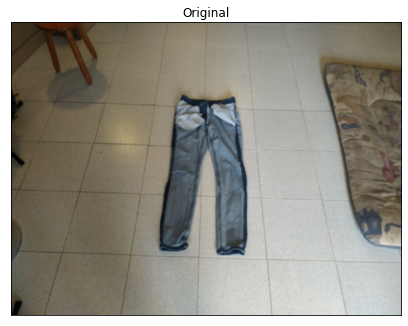

In [17]:
image = cv2.imread(PictureRoute)
showimage(image, pltTitle='Original')

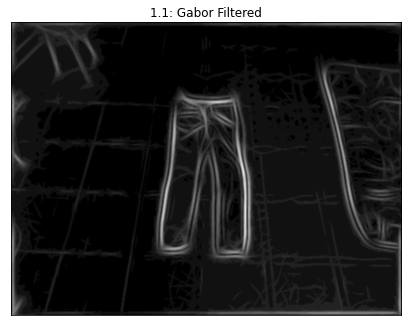

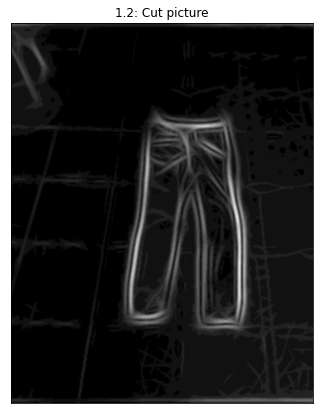

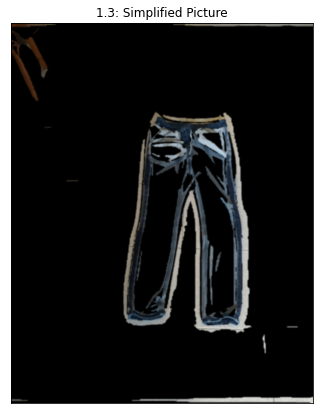

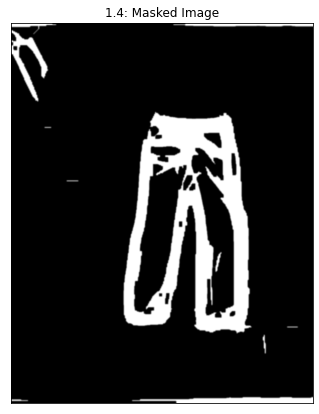

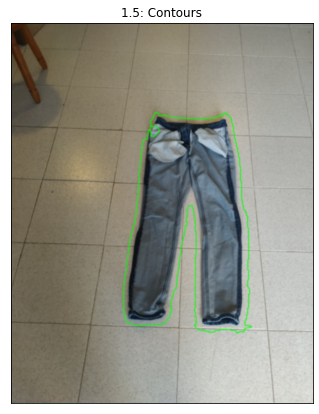

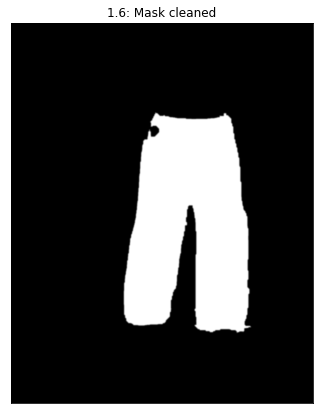

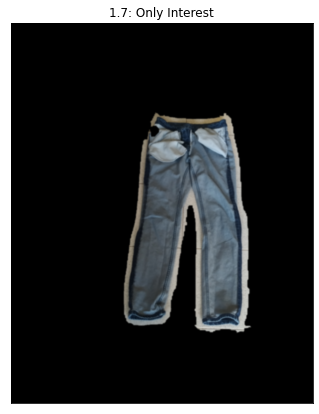

In [18]:
imageCut, imageDown, imageMask,_ = extractBKG1(image,  x1 = x1, x2 = x2,y1 = y1, y2 = y2,DEBUG = True)

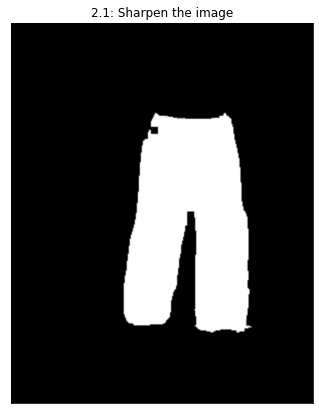

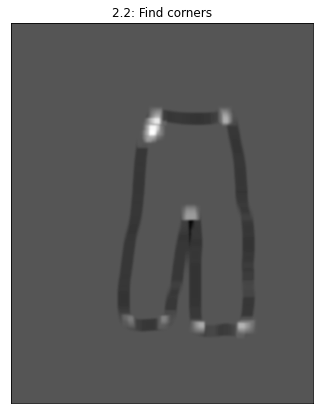

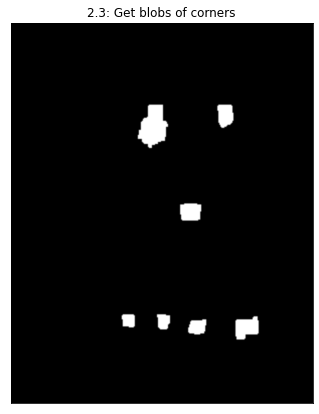

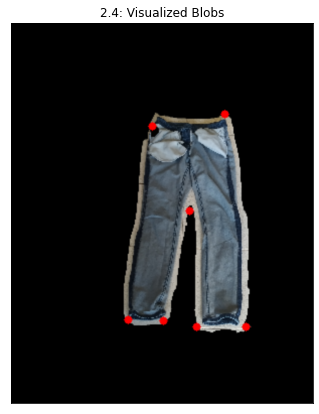

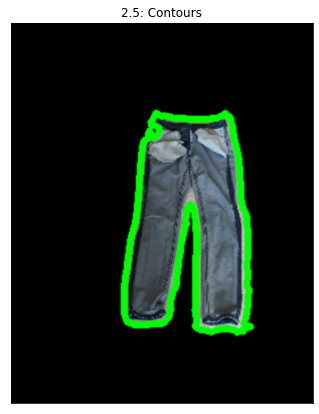

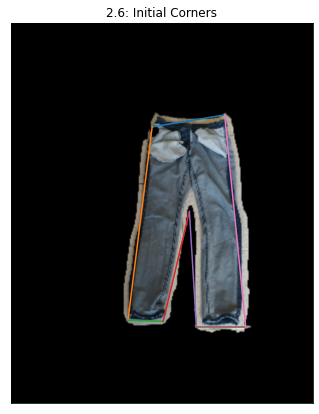

-0.06590149290627755


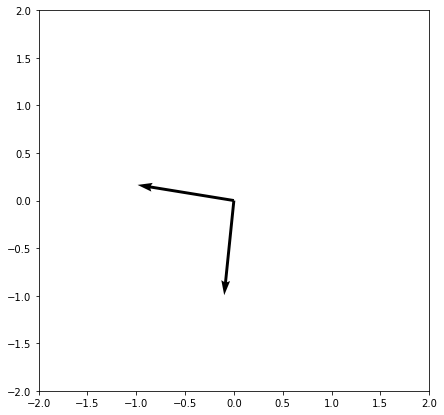

-0.8464402283583525


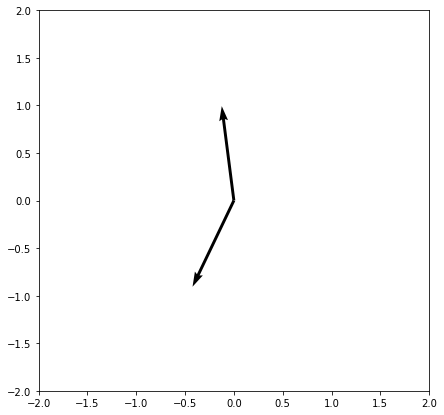

-0.0956449073378253


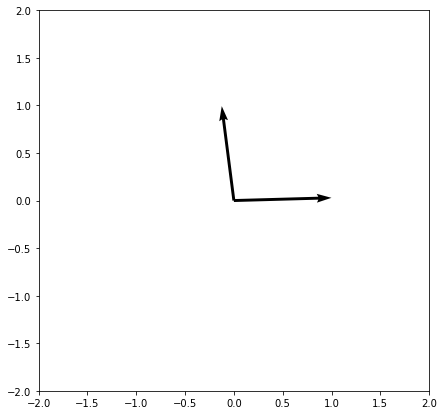

0.2041476259620998


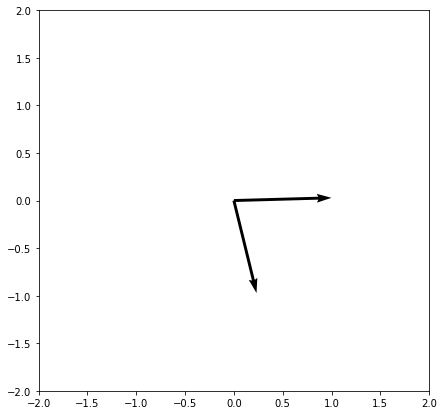

-0.9568163494359242


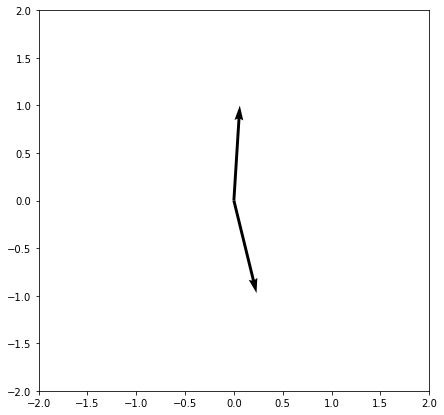

0.06075711357100654


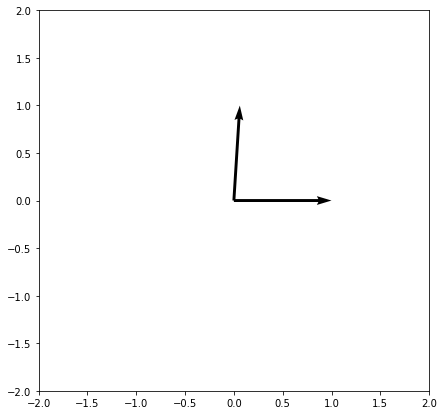

-0.09903677372425176


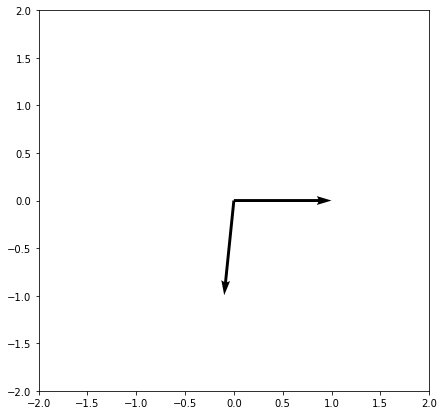

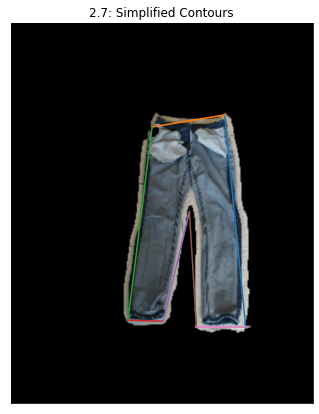

In [19]:
corners, arePants = extractPantsOutline(imageDown,imageMask, 4, DEBUG = True)

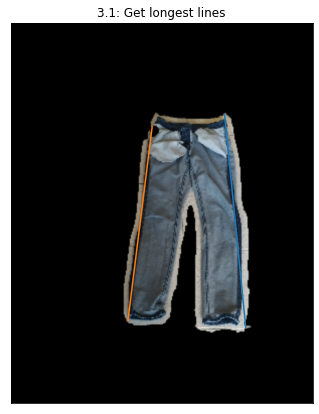

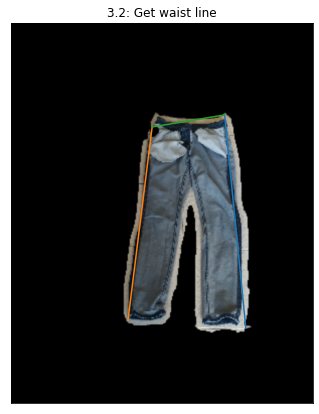

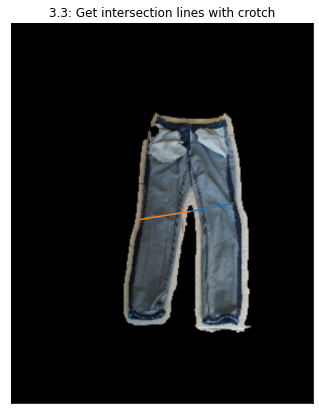

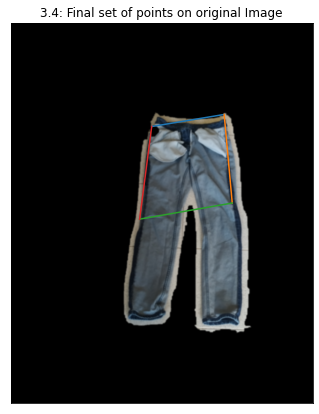

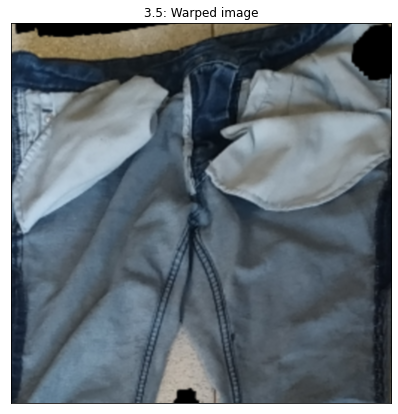

In [20]:
if(arePants):
    result = getTopPants(imageCut, imageDown, imageMask, corners, scalingFactor, DEBUG = True)

In [21]:
def pantsCheck1(image):
    imageCut, imageDown, imageMask,_ = extractBKG1(image,  x1 = x1, x2 = x2,y1 = y1, y2 = y2)
    corners, arePants = extractPantsOutline(imageDown,imageMask, 5)
    if(arePants):
        finalWarpedImage = getTopPants(imageCut, imageDown, imageMask, corners, scalingFactor)
        return finalWarpedImage, True
    return image, False

In [22]:
def pantsCheck2(image):
    imageCut, imageDown, imageMask,_ = extractBKG2(image,  x1 = x1, x2 = x2,y1 = y1, y2 = y2)
    corners, arePants = extractPantsOutline(imageDown,imageMask, 5)
    if(arePants):
        finalWarpedImage = getTopPants(imageCut, imageDown, imageMask, corners, scalingFactor)
        return finalWarpedImage, True
    return image, False

# Saving images

In [23]:
def saveImage(image, baseRoot, folderName, iPath, iFile):
    name = 'P_'+str(iPath)+str(iFile)+'.jpg'
    if not os.path.exists(baseRoot):
        os.mkdir(baseRoot)
    finalDest = os.path.join(baseRoot,folderName)
    if not os.path.exists(finalDest):
        os.mkdir(finalDest)
    finalDest = os.path.join(finalDest,name)
    cv2.imwrite(finalDest, image)
    return finalDest

In [24]:
ReverseDownPath = r'Data\NewDataset\Reverse_Down'
ReverseUpPath = r'Data\NewDataset\Reverse_Up'
RightDownPath = r'Data\NewDataset\Right_Down'
RightUpPath = r'Data\NewDataset\Right_Up'
Labels = ['file','label']
AllPaths = [ReverseDownPath,ReverseUpPath,RightDownPath,RightUpPath]

finalRoute = r'Data\TrimmedPants'
finalCSVName = r'Data\TrimmedPants\pants_dataset.csv'
filesCSV = []

In [26]:
for iPath, path in enumerate(AllPaths):
    if(iPath == 0):
        pathName = "Reverse_Down"
    elif(iPath == 1):
        pathName = "Reverse_Up"
    elif(iPath == 2):
        pathName = "Right_Down"
    else:
        pathName = "Right_Up"

    index = 0
    for files in os.listdir(path):
        finalPath = os.path.join(path, files)
        image = cv2.imread(finalPath)
        pantsPic, arePants = pantsCheck1(image)
        if(arePants == False):
            pantsPic, arePants = pantsCheck2(image)
        if(arePants != False):
            route = saveImage(pantsPic,finalRoute, pathName, iPath, index)
            index += 1
            filesCSV.append([route,pathName])

In [27]:
with open(finalCSVName, 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(Labels) 
    for row in filesCSV:
        csvwriter.writerow(row)

# Step 4: Training the model

In [28]:
import Augmentor
import pandas as pd
from tensorflow.keras.preprocessing import image as imagePrep
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.applications import resnet50
from tensorflow.keras.models import clone_model
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score
import itertools

In [29]:
BATCH_SIZE = 8
EPOCHS = 20
WIDTH = 540
HEIGHT = 540
STEPS_EPOCH = 50

In [30]:
p = Augmentor.Pipeline(finalRoute)
p.resize(1, WIDTH, HEIGHT)
p.flip_left_right(0.5)
p.rotate(probability=0.3, max_left_rotation=5, max_right_rotation=5)
p.skew(0.4, 0.5)#p.zoom(probability = 0.2, min_factor = 1.1, max_factor = 1.5)
p.status()

Initialised with 62 image(s) found.
Output directory set to Data\TrimmedPants\output.Operations: 4
	0: Resize (probability=1 width=540 height=540 resample_filter=BICUBIC )
	1: Flip (probability=0.5 top_bottom_left_right=LEFT_RIGHT )
	2: RotateRange (probability=0.3 max_left_rotation=-5 max_right_rotation=5 )
	3: Skew (probability=0.4 skew_type=RANDOM magnitude=0.5 )
Images: 62
Classes: 4
	Class index: 0 Class label: Reverse_Down 
	Class index: 1 Class label: Reverse_Up 
	Class index: 2 Class label: Right_Down 
	Class index: 3 Class label: Right_Up 
Dimensions: 1
	Width: 255 Height: 255
Formats: 1
	 JPEG

You can remove operations using the appropriate index and the remove_operation(index) function.


In [31]:
train_set = p.keras_generator(batch_size=BATCH_SIZE)

In [32]:
csvFile = pd.read_csv(finalCSVName)
csvFile.head()
generator = imagePrep.ImageDataGenerator()
test_set = generator.flow_from_dataframe(
    dataframe=csvFile,
    x_col="file",
    y_col="label",
    target_size=(WIDTH, HEIGHT),
    batch_size=1,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

Found 62 validated image filenames belonging to 4 classes.


C:\Users\pauso\anaconda3\envs\TFG_Project\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:279: UserWarning: Found 5 invalid image filename(s) in x_col="file". These filename(s) will be ignored.
  warnings.warn(


In [33]:
def checkPointCreation(checkpoint_path):
    print("saving checkpoint")
    checkpoint_dir = os.path.dirname(checkpoint_path)

    # Create a callback that saves the model's weights
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
    return cp_callback

In [34]:
def generateWeights(labels):
    class_weights = class_weight.compute_class_weight('balanced',classes = np.unique(labels),y=labels)
    leng = max(labels)
    class_weight_dict = {i : class_weights[i] for i in range(leng+1)}
    print(class_weight_dict)
    return class_weight_dict

In [35]:
def generateModel(classesAmount):
    input_layer = layers.Input(shape=(WIDTH,HEIGHT,3)) #We set the input layer to the data format we desire

    resNet=resnet50.ResNet50(weights='imagenet', input_tensor=input_layer,include_top=False) #We get the resnet model
    last_layer=resNet.output #We take output layers of resnet
    flatten=layers.Flatten()(last_layer) # Add flatten layer: we are extending Neural Network by adding flattn layer
    
    # Add dense layer to the final output layer
    output_layer = layers.Dense(classesAmount,activation='softmax')(flatten)

    # Creating model with input and output layer
    model=models.Model(inputs=input_layer,outputs=output_layer)
    model.summary()

    for layer in model.layers[:-1]: #Freezing lower layers (in this case only lower layer)
        layer.trainable=False
    model.summary()
    return clone_model(model)

In [36]:
def load_weights(cp_path):
    print("Getting weights")
    current_Epoch = 0
    filepath = ''
    if os.path.exists(cp_path):
        for filename in os.listdir(cp_path):
            f = os.path.join(cp_path, filename)
            # checking if it is a file
            if os.path.isfile(f):
                try:
                    lsp = filename.split('-')[1]
                    num = int(lsp.split('.')[0])
                    if(current_Epoch <= num):
                        current_Epoch = num
                        file = filename.split('.index')[0]
                        filepath = os.path.join(cp_path, file)
                        print(filepath)
                except:
                    print("not this")
        print("Starting from epoch " + str(current_Epoch))
    else:
        os.mkdir(cp_path)
    return current_Epoch, filepath

In [37]:
"""
Function extracted from https://deeplizard.com/learn/video/km7pxKy4UHU to create a confusion matrix
"""
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [38]:
cp_path = "checkPoints/modelTrimmed/cp-{epoch:04d}.ckpt"
cp_callback = checkPointCreation(cp_path)

saving checkpoint


In [39]:
model = generateModel(len(p.class_labels))
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 540, 540, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 546, 546, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 270, 270, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

 conv2_block2_add (Add)         (None, 135, 135, 25  0           ['conv2_block1_out[0][0]',       
                                6)                                'conv2_block2_3_bn[0][0]']      
                                                                                                  
 conv2_block2_out (Activation)  (None, 135, 135, 25  0           ['conv2_block2_add[0][0]']       
                                6)                                                                
                                                                                                  
 conv2_block3_1_conv (Conv2D)   (None, 135, 135, 64  16448       ['conv2_block2_out[0][0]']       
                                )                                                                 
                                                                                                  
 conv2_block3_1_bn (BatchNormal  (None, 135, 135, 64  256        ['conv2_block3_1_conv[0][0]']    
 ization) 

 conv3_block2_3_conv (Conv2D)   (None, 68, 68, 512)  66048       ['conv3_block2_2_relu[0][0]']    
                                                                                                  
 conv3_block2_3_bn (BatchNormal  (None, 68, 68, 512)  2048       ['conv3_block2_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_add (Add)         (None, 68, 68, 512)  0           ['conv3_block1_out[0][0]',       
                                                                  'conv3_block2_3_bn[0][0]']      
                                                                                                  
 conv3_block2_out (Activation)  (None, 68, 68, 512)  0           ['conv3_block2_add[0][0]']       
                                                                                                  
 conv3_blo

                                                                                                  
 conv4_block1_0_bn (BatchNormal  (None, 34, 34, 1024  4096       ['conv4_block1_0_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 conv4_block1_3_bn (BatchNormal  (None, 34, 34, 1024  4096       ['conv4_block1_3_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 conv4_block1_add (Add)         (None, 34, 34, 1024  0           ['conv4_block1_0_bn[0][0]',      
                                )                                 'conv4_block1_3_bn[0][0]']      
                                                                                                  
 conv4_blo

 n)                                                                                               
                                                                                                  
 conv4_block4_3_conv (Conv2D)   (None, 34, 34, 1024  263168      ['conv4_block4_2_relu[0][0]']    
                                )                                                                 
                                                                                                  
 conv4_block4_3_bn (BatchNormal  (None, 34, 34, 1024  4096       ['conv4_block4_3_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 conv4_block4_add (Add)         (None, 34, 34, 1024  0           ['conv4_block3_out[0][0]',       
                                )                                 'conv4_block4_3_bn[0][0]']      
          

 conv5_block1_2_relu (Activatio  (None, 17, 17, 512)  0          ['conv5_block1_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block1_0_conv (Conv2D)   (None, 17, 17, 2048  2099200     ['conv4_block6_out[0][0]']       
                                )                                                                 
                                                                                                  
 conv5_block1_3_conv (Conv2D)   (None, 17, 17, 2048  1050624     ['conv5_block1_2_relu[0][0]']    
                                )                                                                 
                                                                                                  
 conv5_block1_0_bn (BatchNormal  (None, 17, 17, 2048  8192       ['conv5_block1_0_conv[0][0]']    
 ization) 

__________________________________________________________________________________________________
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 540, 540, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 546, 546, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 270, 270, 64  9472        ['conv1_pad[0][0]']              
                                )                                                             

                                                                                                  
 conv2_block2_add (Add)         (None, 135, 135, 25  0           ['conv2_block1_out[0][0]',       
                                6)                                'conv2_block2_3_bn[0][0]']      
                                                                                                  
 conv2_block2_out (Activation)  (None, 135, 135, 25  0           ['conv2_block2_add[0][0]']       
                                6)                                                                
                                                                                                  
 conv2_block3_1_conv (Conv2D)   (None, 135, 135, 64  16448       ['conv2_block2_out[0][0]']       
                                )                                                                 
                                                                                                  
 conv2_blo

                                                                                                  
 conv3_block2_3_conv (Conv2D)   (None, 68, 68, 512)  66048       ['conv3_block2_2_relu[0][0]']    
                                                                                                  
 conv3_block2_3_bn (BatchNormal  (None, 68, 68, 512)  2048       ['conv3_block2_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_add (Add)         (None, 68, 68, 512)  0           ['conv3_block1_out[0][0]',       
                                                                  'conv3_block2_3_bn[0][0]']      
                                                                                                  
 conv3_block2_out (Activation)  (None, 68, 68, 512)  0           ['conv3_block2_add[0][0]']       
          

                                )                                                                 
                                                                                                  
 conv4_block1_0_bn (BatchNormal  (None, 34, 34, 1024  4096       ['conv4_block1_0_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 conv4_block1_3_bn (BatchNormal  (None, 34, 34, 1024  4096       ['conv4_block1_3_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 conv4_block1_add (Add)         (None, 34, 34, 1024  0           ['conv4_block1_0_bn[0][0]',      
                                )                                 'conv4_block1_3_bn[0][0]']      
          

 conv4_block4_2_relu (Activatio  (None, 34, 34, 256)  0          ['conv4_block4_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block4_3_conv (Conv2D)   (None, 34, 34, 1024  263168      ['conv4_block4_2_relu[0][0]']    
                                )                                                                 
                                                                                                  
 conv4_block4_3_bn (BatchNormal  (None, 34, 34, 1024  4096       ['conv4_block4_3_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 conv4_block4_add (Add)         (None, 34, 34, 1024  0           ['conv4_block3_out[0][0]',       
          

                                                                                                  
 conv5_block1_2_relu (Activatio  (None, 17, 17, 512)  0          ['conv5_block1_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block1_0_conv (Conv2D)   (None, 17, 17, 2048  2099200     ['conv4_block6_out[0][0]']       
                                )                                                                 
                                                                                                  
 conv5_block1_3_conv (Conv2D)   (None, 17, 17, 2048  1050624     ['conv5_block1_2_relu[0][0]']    
                                )                                                                 
                                                                                                  
 conv5_blo

Total params: 25,955,204
Trainable params: 2,367,492
Non-trainable params: 23,587,712
__________________________________________________________________________________________________


In [40]:
currentEpoch, file = load_weights("checkPoints/modelTrimmed")
if(currentEpoch != 0):
    model.load_weights(file)

Getting weights


In [41]:
model.fit(train_set,steps_per_epoch=STEPS_EPOCH,epochs=EPOCHS,initial_epoch = currentEpoch,verbose=True, callbacks=[cp_callback])

Epoch 1/20
50/50 [==============================] - ETA: 0s - loss: 2.1122 - accuracy: 0.4675
Epoch 1: saving model to checkPoints/modelTrimmed\cp-0001.ckpt
50/50 [==============================] - 18s 269ms/step - loss: 2.1122 - accuracy: 0.4675
Epoch 2/20
50/50 [==============================] - ETA: 0s - loss: 0.7029 - accuracy: 0.7450
Epoch 2: saving model to checkPoints/modelTrimmed\cp-0002.ckpt
50/50 [==============================] - 14s 280ms/step - loss: 0.7029 - accuracy: 0.7450
Epoch 3/20
50/50 [==============================] - ETA: 0s - loss: 0.7209 - accuracy: 0.7475
Epoch 3: saving model to checkPoints/modelTrimmed\cp-0003.ckpt
50/50 [==============================] - 14s 288ms/step - loss: 0.7209 - accuracy: 0.7475
Epoch 4/20
50/50 [==============================] - ETA: 0s - loss: 0.7031 - accuracy: 0.7475
Epoch 4: saving model to checkPoints/modelTrimmed\cp-0004.ckpt
50/50 [==============================] - 14s 275ms/step - loss: 0.7031 - accuracy: 0.7475
Epoch 5/20
5

In [42]:
if(currentEpoch < EPOCHS):
    model.save('saved_model/trimmed')

INFO:tensorflow:Assets written to: saved_model/trimmed\assets


In [43]:
model = models.load_model('saved_model/trimmed')

In [44]:
predictions = model.predict(test_set)
rounded_predictions = np.argmax(predictions, axis=-1)
model.evaluate(test_set)

62/62 [==============================] - 4s 43ms/step - loss: 0.0000e+00 - accuracy: 1.0000


[0.0, 1.0]

Confusion matrix, without normalization
[[4 2 1 6]
 [3 7 4 3]
 [1 4 4 4]
 [5 4 4 6]]


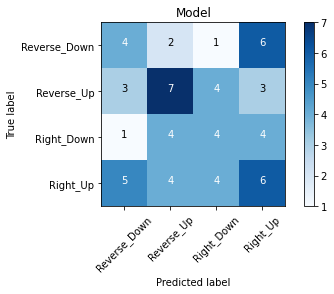

In [45]:
cm = confusion_matrix(y_true=test_set.labels, y_pred=rounded_predictions)
plot_confusion_matrix(cm=cm, classes=test_set.class_indices, title='Model')

# Final method

In [46]:
TargetPicture = r'Data\NewDataset\Reverse_Up\1652615425124.jpg'

In [47]:
def predictPants(route):
    model = models.load_model('saved_model/trimmed')
    image = cv2.imread(route)
    showimage(image)
    pantsPic, arePants = pantsCheck1(image)
    if(arePants == False):
        pantsPic, arePants = pantsCheck2(image)
    if(arePants != False):
        reshaped = cv2.resize(pantsPic, dsize = (WIDTH, HEIGHT),interpolation= cv2.INTER_LINEAR)
        reshaped = reshaped.reshape(1, WIDTH, HEIGHT, 3)
        prediction = model.predict(reshaped)
        prediction = np.argmax(prediction, axis=-1)
        if(prediction == 0):
            typePants = "Reverse_Down"
        elif(prediction == 1):
            typePants = "Reverse_Up"
        elif(prediction == 2):
            typePants = "Right_Down"
        else:
            typePants = "Right_Up"
        return typePants, True
    return "Not Pants", False

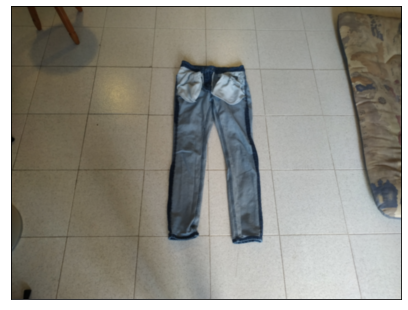

('Reverse_Up', True)


In [48]:
pantsType = predictPants(TargetPicture)
print(pantsType)